## F@H FEP/ML hybrid 

#### Code for correcting AFE calculations in a F@H virtual screen by using temporal/ sequential learning
Collaboration between Julien Michel & John Chodera groups

Code by:
- Jenke Scheen
- Julien Michel

In [17]:
import hydra

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

## Data preparation

In [2]:
# for now, provide toy set of perturbations:
# currently code just repeats these 3 points *300. Remove when real dataset is used.
perturbation_paths = [
        ["mobley_9185328~mobley_9185328"],
        ["mobley_9209581~mobley_9565165"],
        ["mobley_9209581~mobley_9821936"]]

# compute ligand molecular properties from DB path
hydra.computeLigMolProps("./input/ligands/")
pass

Computing molecular properties:


100%|██████████| 43/43 [00:01<00:00, 22.85it/s]


In [3]:
# using stored molprops and list of perturbations, compute relative features (subtract/concat bitstrings):
hydra.computePertMolProps(perturbation_paths=perturbation_paths)

100%|██████████| 3/3 [00:00<00:00, 185.80it/s]


In [4]:
# labels/labels.csv constructed in bash, follow same format for real dataset. Combine labels and features; 
# requires length/indices matching:

hydra.buildTrainingSet(
    "labels/labels.csv", 
    "features/MOLPROPS/featurised_molprops.h5", 
    "trainingsets/MOLPROPS_trainingset.h5", 
    )

100%|██████████| 3/3 [00:00<00:00, 91.30it/s]


In [5]:
# PCA + normalise dataset. Process in chunks so that we can potentially handle larger datasets with linear scaling:
hydra.normaliseDataset(
                path_to_raw_trainingset="trainingsets/MOLPROPS_trainingset.h5",
                path_to_save_loc="trainingsets_prepared/",
                feature_type="MOLPROPS", 
                chunksize=6000)

# because of split processing in this function, n_components has to be found manually (see commented section in fn)


Making first pass (partial fitting)..
Making second pass (partial transform + partial PCA fit)..
Making third pass (normalise and PCA transform)..


In [6]:
# construct dataset splits necessary for tensorflow/sklearn:

X_train, y_train, X_test, y_test = hydra.importDataSet(
                    "ddGoffset", 
                    "trainingsets_prepared/MOLPROPS/data.h5")

## Train models

In [7]:
# construct DNN training function:
fitness, dimensions, default_parameters = hydra.denseNN(
                                        X_train, 
                                        y_train, 
                                        X_test, 
                                        y_test, 
                                        "MOLPROPS")



In [8]:
# use SKOPT to optimise hyperparameters & write outputs:
n_calls = 11

hydra.trainCorrector(fitness, dimensions, n_calls, default_parameters)

Training: 100%|██████████| 11/11 [00:58<00:00,  4.40s/it]

## Output analysis

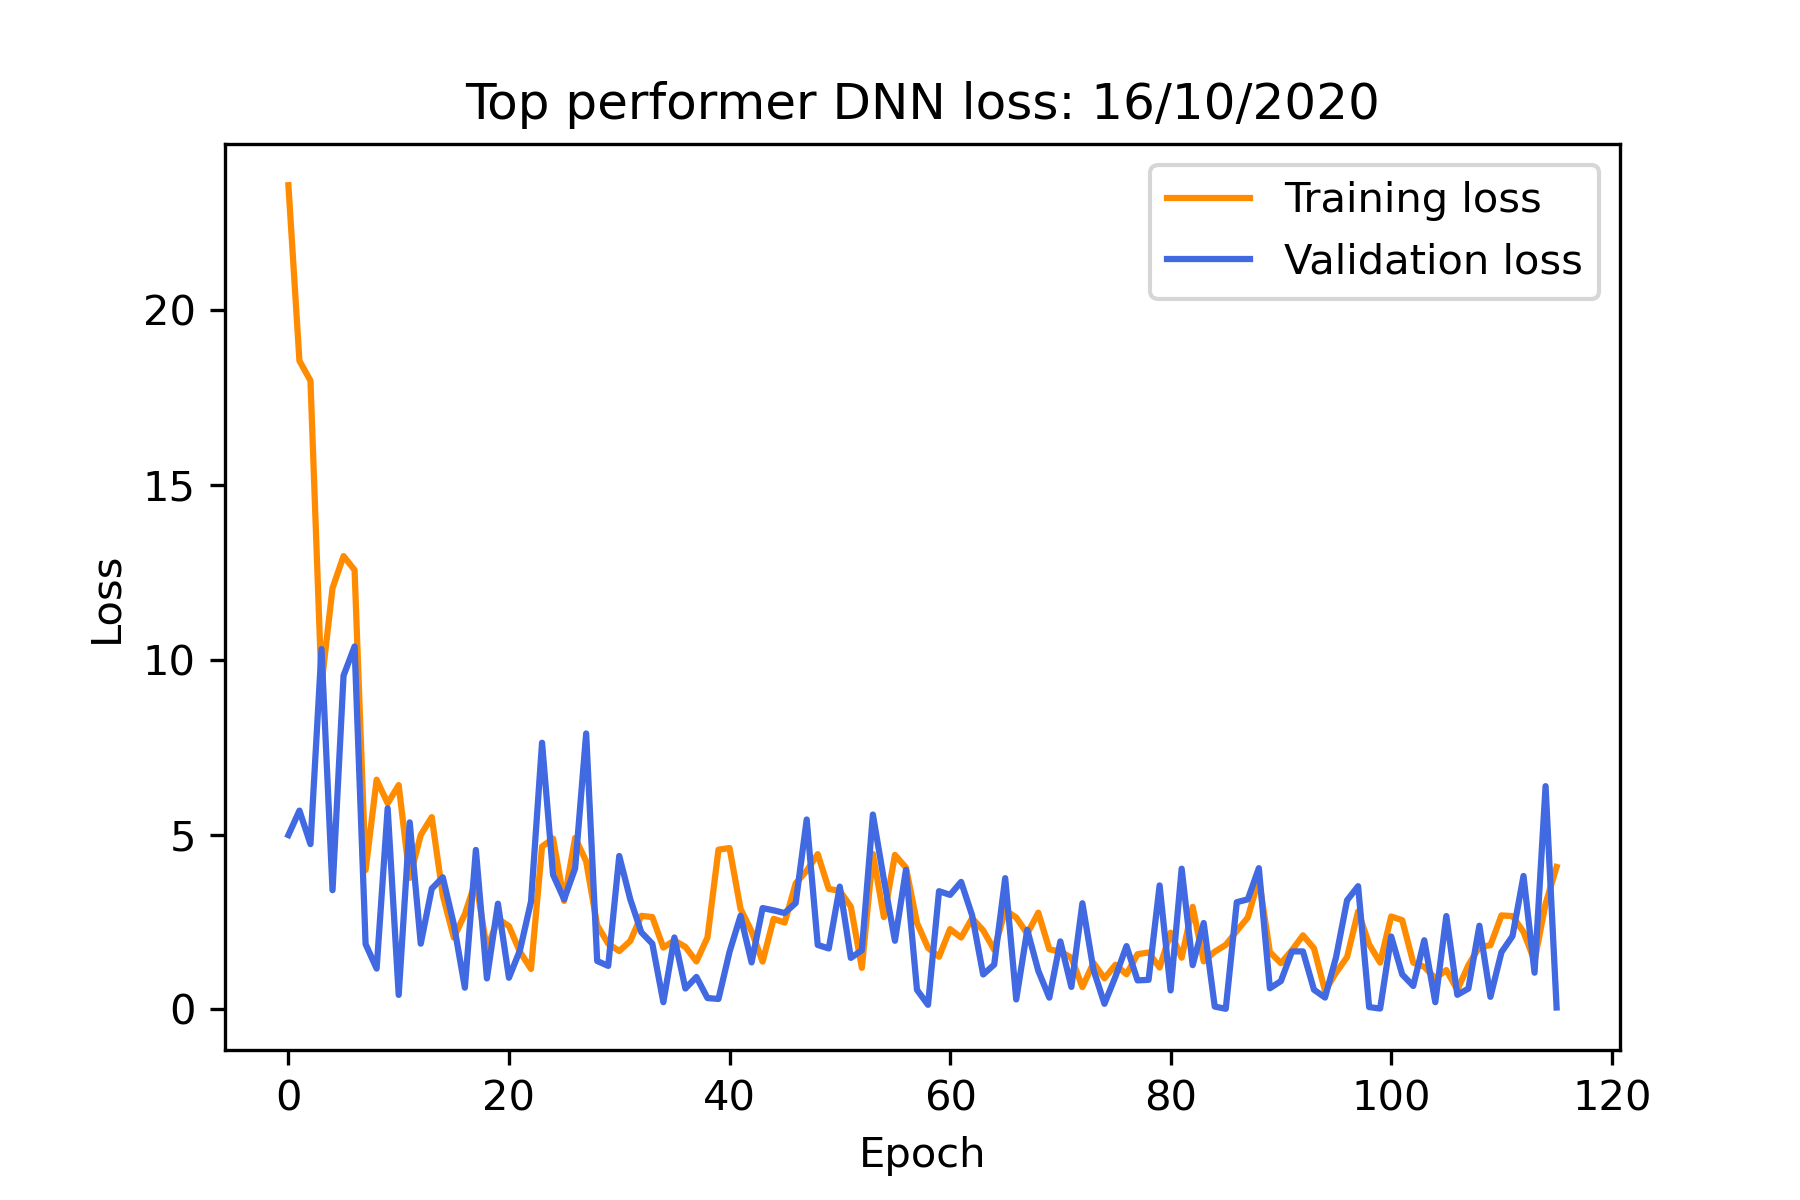

In [9]:
# show standard loss plot of DNN architecture with best loss after hyperparameter optimisation:
from IPython.display import Image
Image(filename='output/MOLPROPS_top_performer_loss_plot.png', width=600, height=300) 


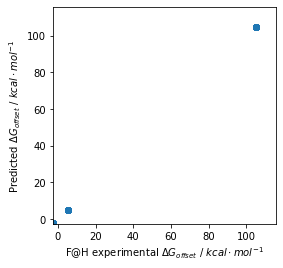

In [47]:
# plot above model's predictions:

# read in predictions:
model_preds = pd.read_csv("output/MOLPROPS_top_performer.csv")

# plot simple scatter:
fig, axes = plt.subplots(1,1, figsize=(4,4))
ax = axes # change in case of multiple subplots

exp = model_preds["Exp1"].values.tolist()
pred = model_preds["Pred1"].values.tolist()

ax.scatter(exp, pred)

# figure out limits:
max_lim = max(exp + pred)*1.1
min_lim = min(exp + pred)*1.1
ax.set_ylim(min_lim, max_lim)
ax.set_xlim(min_lim, max_lim)

# formatting:
ax.set_ylabel(r"Predicted $\Delta G_{offset}\ /\ kcal\cdot mol^{-1}$")
ax.set_xlabel(r"F@H experimental $\Delta G_{offset}\ /\ kcal\cdot mol^{-1}$")
plt.show()

In [10]:
# here use function to plot hyperparameter config convergence:




In [ ]:
# here use function to correct and validate FEP/ML hybrid:


